# Imports


In [1]:
import os, time, random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm
import torchvision.models as models
import torchvision.models.segmentation as segmodels

# PATHS

In [2]:
IMG_DIR  = "/kaggle/input/isicdata/ISIC2018/ISIC2018/images_aug_20000"
MASK_DIR = "/kaggle/input/isicdata/ISIC2018/ISIC2018/masks_aug_20000"
IMG_EXT  = ".jpg"
MASK_EXT = ".png"


SEED   = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

EPOCHS = 3 
LR_LIST    = [1e-4, 3e-5, 1e-5]    
BATCH_LIST = [4, 8, 16]           


TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

SAVE_DIR = "saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)
print("SAVE_DIR:", os.path.abspath(SAVE_DIR))


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


Device: cuda
SAVE_DIR: /kaggle/working/saved_models


# TRANSFORMS

In [3]:
train_tfms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=20, p=0.7),
    A.Normalize(),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# DATASET

In [4]:
class ISICSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, ids, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path  = os.path.join(self.img_dir, img_id + IMG_EXT)
        mask_path = os.path.join(self.mask_dir, img_id + MASK_EXT)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(mask_path)
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            out = self.transform(image=img, mask=mask)
            img = out["image"]
            mask = out["mask"]

        return img, mask.unsqueeze(0)  



In [5]:
def find_dirs(dir_name, start="/kaggle/input"):
    hits = []
    for root, dirs, files in os.walk(start):
        if dir_name in dirs:
            hits.append(os.path.join(root, dir_name))
    return hits

img_hits  = find_dirs("images_aug_20000")
mask_hits = find_dirs("masks_aug_20000")

print("Found image dirs:")
for p in img_hits: print(" -", p)

print("\nFound mask dirs:")
for p in mask_hits: print(" -", p)

assert len(img_hits) > 0, "Could not find images_aug_20000 anywhere under /kaggle/input"
assert len(mask_hits) > 0, "Could not find masks_aug_20000 anywhere under /kaggle/input"


IMG_DIR  = img_hits[0]
MASK_DIR = mask_hits[0]

print("\n✅ Using:")
print("IMG_DIR :", IMG_DIR)
print("MASK_DIR:", MASK_DIR)


print("\nCounts:")
print("Images:", len(os.listdir(IMG_DIR)))
print("Masks :", len(os.listdir(MASK_DIR)))


Found image dirs:
 - /kaggle/input/ISIC2018/ISIC2018/images_aug_20000

Found mask dirs:
 - /kaggle/input/ISIC2018/ISIC2018/masks_aug_20000

✅ Using:
IMG_DIR : /kaggle/input/ISIC2018/ISIC2018/images_aug_20000
MASK_DIR: /kaggle/input/ISIC2018/ISIC2018/masks_aug_20000

Counts:
Images: 20001
Masks : 20001


In [6]:
all_ids = sorted([f.replace(IMG_EXT, "") for f in os.listdir(IMG_DIR) if f.endswith(IMG_EXT)])
print("Total IDs:", len(all_ids))
print("Example IDs:", all_ids[:5])

Total IDs: 20000
Example IDs: ['ISIC_0000000', 'ISIC_0000000_aug_005082', 'ISIC_0000000_aug_010963', 'ISIC_0000001', 'ISIC_0000001_aug_002315']


# 3-WAY SPLIT

In [7]:
def split_ids_three_way(ids, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    rng = np.random.RandomState(seed)
    ids = np.array(ids)
    rng.shuffle(ids)

    n = len(ids)
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)
    train_ids = ids[:n_train].tolist()
    val_ids   = ids[n_train:n_train+n_val].tolist()
    test_ids  = ids[n_train+n_val:].tolist()
    return train_ids, val_ids, test_ids

train_ids, val_ids, test_ids = split_ids_three_way(all_ids, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, SEED)
print(f"Split sizes: train={len(train_ids)}, val={len(val_ids)}, test={len(test_ids)}")


Split sizes: train=14000, val=3000, test=3000


# VISUALIZATION: samples

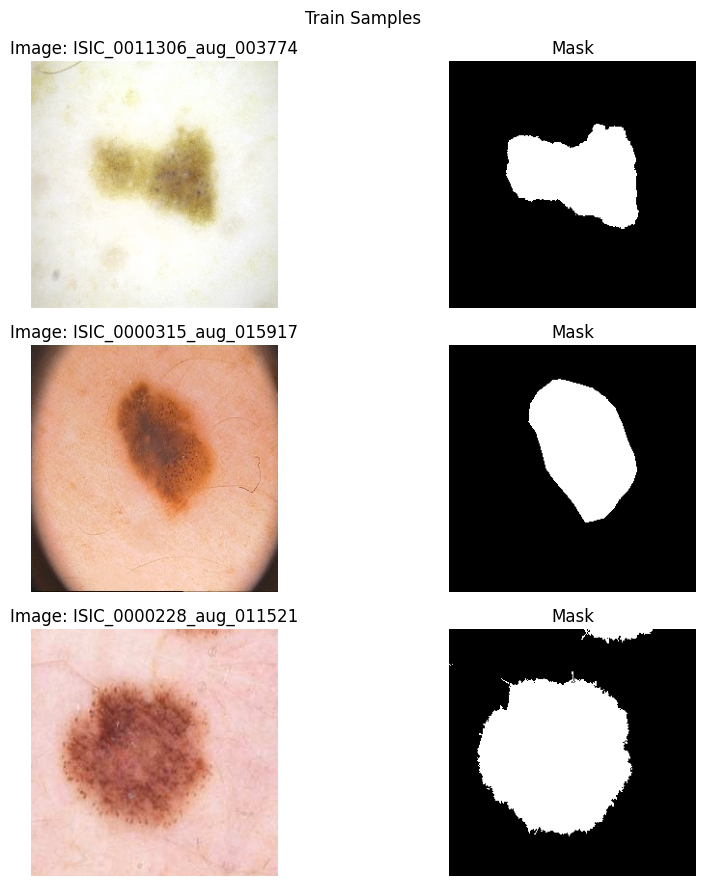

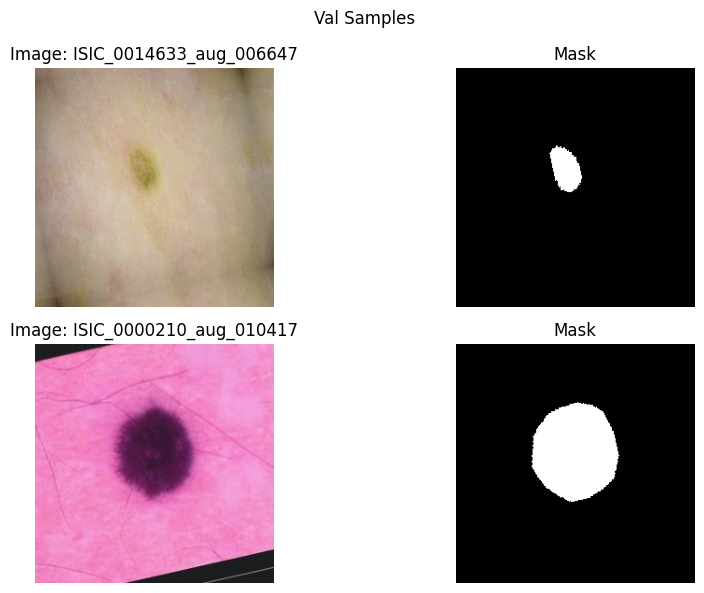

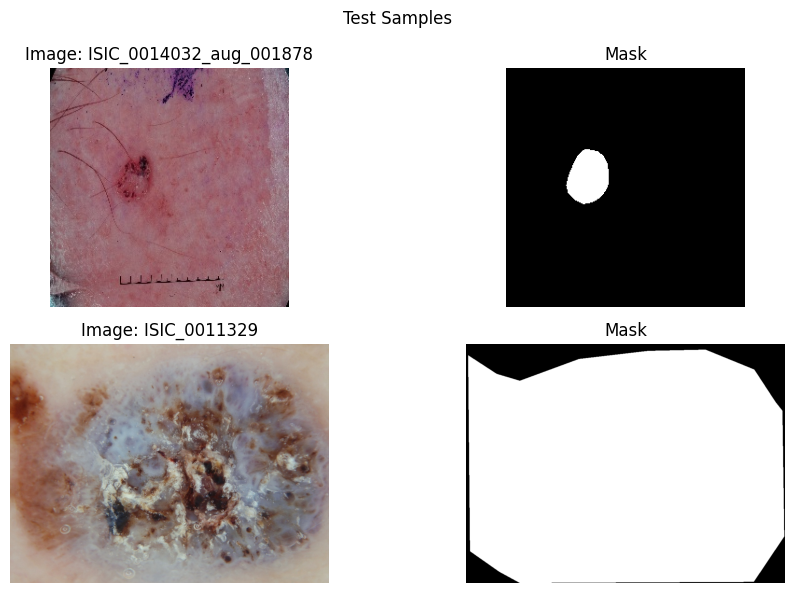

In [8]:
def show_samples(ids, n=3, title="Samples"):
    pick = np.random.choice(ids, n, replace=False)
    plt.figure(figsize=(10, 3*n))
    for i, img_id in enumerate(pick, 1):
        img = cv2.imread(os.path.join(IMG_DIR, img_id + IMG_EXT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASK_DIR, img_id + MASK_EXT), 0)

        plt.subplot(n, 2, 2*i-1)
        plt.imshow(img); plt.axis("off"); plt.title(f"Image: {img_id}")

        plt.subplot(n, 2, 2*i)
        plt.imshow(mask, cmap="gray"); plt.axis("off"); plt.title("Mask")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_ids, n=3, title="Train Samples")
show_samples(val_ids, n=2, title="Val Samples")
show_samples(test_ids, n=2, title="Test Samples")


# METRICS + LOSSES

In [9]:
bce_logits = nn.BCEWithLogitsLoss()

@torch.no_grad()
def dice_from_logits(logits, target, eps=1e-6):
    prob = torch.sigmoid(logits)
    pred = (prob > 0.5).float()
    inter = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

def soft_dice_loss_from_logits(logits, target, eps=1e-6):
    prob = torch.sigmoid(logits)
    inter = (prob * target).sum(dim=(2,3))
    union = prob.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()


# MODELS

In [10]:
def FCN_R50():
    m = segmodels.fcn_resnet50(weights="DEFAULT")
    m.classifier[4] = nn.Conv2d(512, 1, kernel_size=1)
    if hasattr(m, "aux_classifier") and m.aux_classifier is not None:
        m.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
    return m

In [11]:
class SegNet(nn.Module):
 
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c, n=2):
            layers = []
            c = in_c
            for _ in range(n):
                layers += [nn.Conv2d(c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)]
                c = out_c
            return nn.Sequential(*layers)

        self.enc1 = conv_block(3, 64, n=2)
        self.enc2 = conv_block(64, 128, n=2)
        self.enc3 = conv_block(128, 256, n=3)
        self.enc4 = conv_block(256, 512, n=3)

        self.pool = nn.MaxPool2d(2, 2)

        self.dec4 = conv_block(512, 256, n=2)
        self.dec3 = conv_block(256, 128, n=2)
        self.dec2 = conv_block(128, 64,  n=2)
        self.dec1 = conv_block(64,  64,  n=1)

        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)     
        x  = self.pool(x1)    
        x2 = self.enc2(x)
        x  = self.pool(x2)     
        x3 = self.enc3(x)
        x  = self.pool(x3)    
        x4 = self.enc4(x)      

        x = self.up(x4)       
        x = self.dec4(x)
        x = self.up(x)         
        x = self.dec3(x)
        x = self.up(x)         
        x = self.dec2(x)
        x = self.dec1(x)
        return self.out(x)

# forward wrapper

In [12]:
def model_forward(model, x, arch_name):
    if arch_name == "FCN_R50":
        return model(x)["out"]
    return model(x)


# TRAIN / EVAL

In [13]:
def train_one_model(model, arch_name, train_loader, val_loader, epochs, lr):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"train_loss": [], "val_loss": [], "train_dice": [], "val_dice": []}

    for ep in range(1, epochs + 1):
      
        model.train()
        tr_loss_sum, tr_dice_sum = 0.0, 0.0

        loop = tqdm(train_loader, desc=f"{arch_name} | Ep {ep}/{epochs} [TRAIN]", leave=False)
        for xb, yb in loop:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            logits = model_forward(model, xb, arch_name)
            loss = 0.5*bce_logits(logits, yb) + 0.5*soft_dice_loss_from_logits(logits, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            tr_loss_sum += loss.item()
            tr_dice_sum += dice_from_logits(logits, yb)
            loop.set_postfix(loss=f"{loss.item():.4f}")

       
        model.eval()
        va_loss_sum, va_dice_sum = 0.0, 0.0
        n_batches = 0

        with torch.no_grad():
            loop2 = tqdm(val_loader, desc=f"{arch_name} | Ep {ep}/{epochs} [VAL]", leave=False)
            for xb, yb in loop2:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)

                logits = model_forward(model, xb, arch_name)
                vloss = 0.5*bce_logits(logits, yb) + 0.5*soft_dice_loss_from_logits(logits, yb)
                vdice = dice_from_logits(logits, yb)

                va_loss_sum += vloss.item()
                va_dice_sum += vdice
                n_batches += 1
                loop2.set_postfix(vloss=f"{vloss.item():.4f}")

        tr_loss = tr_loss_sum / max(1, len(train_loader))
        va_loss = va_loss_sum / max(1, n_batches)
        tr_dice = tr_dice_sum / max(1, len(train_loader))
        va_dice = va_dice_sum / max(1, n_batches)

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_dice"].append(tr_dice)
        hist["val_dice"].append(va_dice)

        print(f"{arch_name} | Epoch {ep}/{epochs} | TrainDice={tr_dice:.4f} | ValDice={va_dice:.4f}")

    return hist, model

In [14]:
@torch.no_grad()
def evaluate_model(model, arch_name, loader, title="EVAL"):
    model.eval()
    loss_sum, dice_sum = 0.0, 0.0
    n_batches = 0

    for xb, yb in tqdm(loader, desc=f"{arch_name} | {title}", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model_forward(model, xb, arch_name)
        loss = 0.5*bce_logits(logits, yb) + 0.5*soft_dice_loss_from_logits(logits, yb)
        dice = dice_from_logits(logits, yb)
        loss_sum += loss.item()
        dice_sum += dice
        n_batches += 1

    return (loss_sum / max(1, n_batches)), (dice_sum / max(1, n_batches))

# SAVE / LOAD

In [15]:
def save_model_state(model, arch, lr, batch, val_dice, tag="best"):
    os.makedirs("saved_models", exist_ok=True)
    path = f"saved_models/{arch}_LR{lr}_B{batch}_{tag}_val{val_dice:.4f}.pth"
    torch.save(model.state_dict(), path)
    print("✅ Saved:", path)
    return path

def load_model_state(model, path):
    sd = torch.load(path, map_location=DEVICE)
    model.load_state_dict(sd)
    return model

def list_saved_models():
    files = sorted(glob.glob(os.path.join(SAVE_DIR, "*.pth")))
    print("Saved .pth files:")
    for f in files:
        print(" -", f)
    return files

In [16]:
import os, glob
print("cwd:", os.getcwd())
print("saved_models exists:", os.path.exists("saved_models"))
print("pth files:", glob.glob("**/*.pth", recursive=True)[:30])


cwd: /kaggle/working
saved_models exists: True
pth files: []


# LEARNING CURVE PLOT

In [17]:
def plot_learning_curve(hist, title="Learning Curve"):
    epochs = list(range(1, len(hist["train_dice"]) + 1))
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, hist["train_dice"], marker="o", label="Train Dice")
    plt.plot(epochs, hist["val_dice"], marker="s", label="Val Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# visualization


In [18]:
@torch.no_grad()
def visualize_predictions(model, arch_name, ids_pool, n=3):
    model.eval()
    pick = np.random.choice(ids_pool, n, replace=False)

    cols = 3 
    plt.figure(figsize=(4*cols, 4*n))

    for i, img_id in enumerate(pick, 1):
       
        img = cv2.imread(os.path.join(IMG_DIR, img_id + IMG_EXT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gt  = cv2.imread(os.path.join(MASK_DIR, img_id + MASK_EXT), 0)

        
        ds_tmp = ISICSegDataset(IMG_DIR, MASK_DIR, [img_id], transform=val_tfms)
        x, _ = ds_tmp[0]
        x = x.unsqueeze(0).to(DEVICE)

        logits = model_forward(model, x, arch_name)
        prob = torch.sigmoid(logits)[0,0].cpu().numpy()
        pred = (prob > 0.5).astype(np.uint8) * 255

        r = i - 1
        plt.subplot(n, cols, r*cols + 1)
        plt.imshow(img); plt.axis("off"); plt.title(f"Image\n{img_id}")

        plt.subplot(n, cols, r*cols + 2)
        plt.imshow(gt, cmap="gray"); plt.axis("off"); plt.title("GT")

        plt.subplot(n, cols, r*cols + 3)
        plt.imshow(pred, cmap="gray"); plt.axis("off"); plt.title(f"Pred ({arch_name})")

    plt.tight_layout()
    plt.show()

# DATALOADERS (fixed split)

In [19]:
train_ds = ISICSegDataset(IMG_DIR, MASK_DIR, train_ids, transform=train_tfms)
val_ds   = ISICSegDataset(IMG_DIR, MASK_DIR, val_ids, transform=val_tfms)
test_ds  = ISICSegDataset(IMG_DIR, MASK_DIR, test_ids, transform=val_tfms)


# FCN BEST RUN

In [20]:
BEST_FCN_LR = 3e-05
BEST_FCN_B  = 16
BEST_FCN_E  = 3

fcn_train_ld = DataLoader(train_ds, batch_size=BEST_FCN_B, shuffle=True,  num_workers=0, drop_last=True)
fcn_val_ld   = DataLoader(val_ds,   batch_size=BEST_FCN_B, shuffle=False, num_workers=0)

model_fcn = FCN_R50().to(DEVICE)
hist_fcn, model_fcn = train_one_model(model_fcn, "FCN_R50", fcn_train_ld, fcn_val_ld, epochs=BEST_FCN_E, lr=BEST_FCN_LR)

fcn_best_path = save_model_state(
    model_fcn,
    "FCN_R50",
    BEST_FCN_LR,
    BEST_FCN_B,
    hist_fcn["val_dice"][-1]
)


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


100%|██████████| 135M/135M [00:00<00:00, 157MB/s]  


FCN_R50 | Epoch 1/3 | TrainDice=0.8529 | ValDice=0.8911


FCN_R50 | Epoch 2/3 | TrainDice=0.8953 | ValDice=0.9001


FCN_R50 | Epoch 3/3 | TrainDice=0.9042 | ValDice=0.9071
✅ Saved: saved_models/FCN_R50_LR3e-05_B16_best_val0.9071.pth


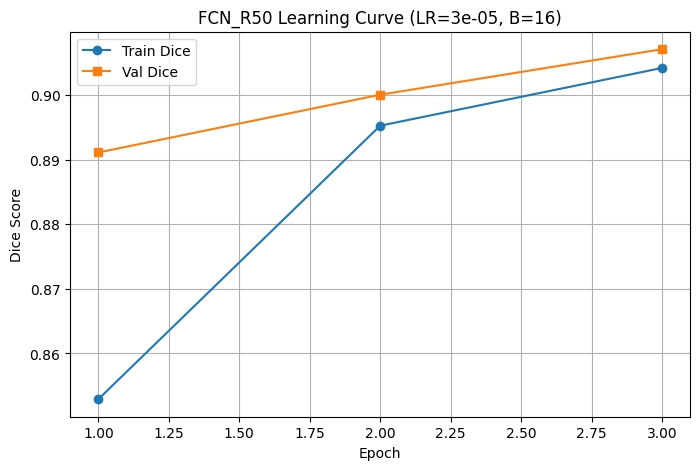

In [21]:
plot_learning_curve(hist_fcn, title=f"FCN_R50 Learning Curve (LR={BEST_FCN_LR}, B={BEST_FCN_B})")

# TEST EVALUATION (best saved model)

In [23]:
print("\n" + "#"*80)
print("TEST EVALUATION (Using Best Saved Models)")
print("#"*80)

test_ld = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0)


model_fcn_test = FCN_R50()
model_fcn_test = load_model_state(model_fcn_test, fcn_best_path).to(DEVICE)
test_loss_fcn, test_dice_fcn = evaluate_model(model_fcn_test, "FCN_R50", test_ld, title="TEST")
print(f"FCN_R50 | TEST Loss={test_loss_fcn:.4f} | TEST Dice={test_dice_fcn:.4f}")



################################################################################
TEST EVALUATION (Using Best Saved Models)
################################################################################


FCN_R50 | TEST Loss=0.1028 | TEST Dice=0.9049


# VISUALIZE PREDICTIONS 


Showing prediction visualizations on TEST set...


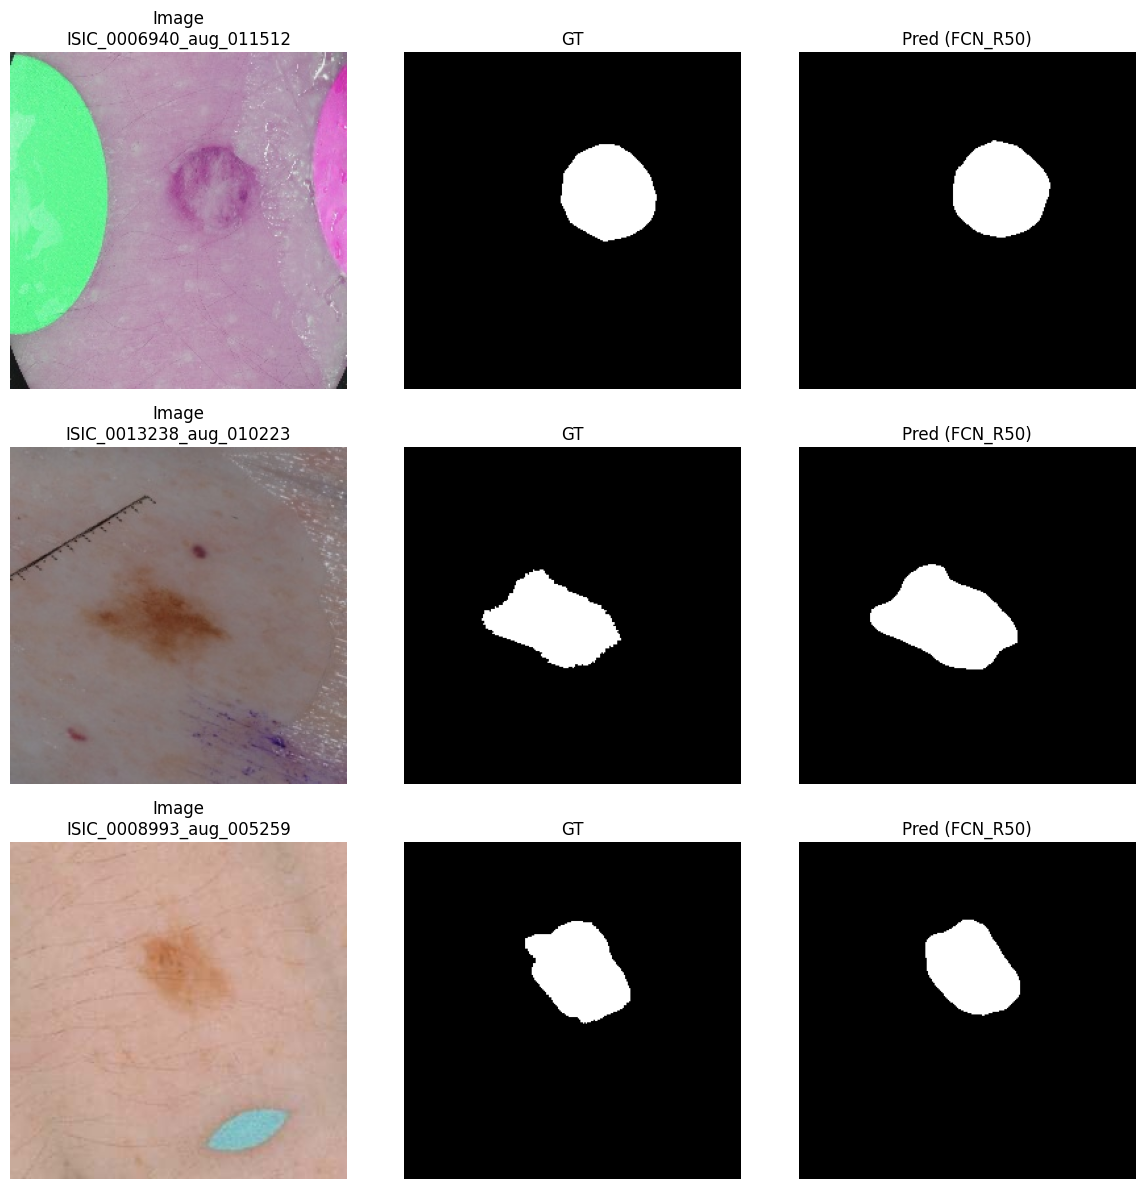

In [24]:
print("\nShowing prediction visualizations on TEST set...")

visualize_predictions(model_fcn_test, "FCN_R50", test_ids, n=3)



#  ZIP SAVED MODELS 

In [25]:
!zip -r saved_models.zip saved_models
print("✅ Created saved_models.zip")

  adding: saved_models/ (stored 0%)
  adding: saved_models/FCN_R50_LR3e-05_B16_best_val0.9071.pth (deflated 7%)
✅ Created saved_models.zip
